# Diagonalizing a Sensing Matrix

Text(0.5, 0, 'Frequency (Hz)')

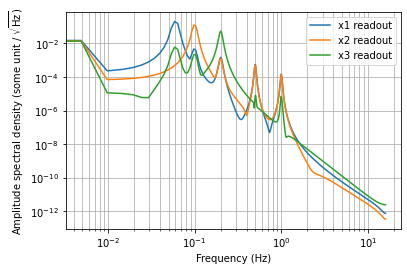

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy

import kontrol


# Setup and virtually obtain the measurements
# Ignore the first and second block if you're not interested in how the
# data was generated.

# Original sensing matrix.
# Usually obtained from first priniciples, i.e. geometry
# This sensing matrix in particular is a sensing matrix for the LVDT sensors
# at the inverted pendulum stage.
sensing_matrix_inv = [
    [-np.sin(30*np.pi/180), np.cos(30*np.pi/180), 1],
    [-np.sin(150*np.pi/180), np.cos(150*np.pi/180), 1],
    [-np.sin(270*np.pi/180), np.cos(270*np.pi/180), 1]
]
sensing_matrix = np.linalg.inv(np.array(sensing_matrix_inv))
#
# Define the dymanics of the system
# Let's say x1 resonant at 0.06 Hz, x2 resonant at 0.1 Hz, and x3 0.2 Hz.
# To make things more complicated, let's assume there're two x1-x2 coupled modes, at 0.5 and 1 Hz.
s = control.tf("s")
fs = 32
t = np.linspace(0, 1024, 1024*fs)
# 5 modes
w1 = 0.06*2*np.pi
w2 = 0.1*2*np.pi
w3 = 0.2*2*np.pi
w4 = 0.5*2*np.pi
w5 = 1*2*np.pi
q1 = 10
q2 = 10
q3 = 10
q4 = 20
q5 = 20
tf1 = w1**2 / (s**2+w1/q1*s+w1**2)
tf2 = w2**2 / (s**2+w2/q2*s+w2**2)
tf3 = w3**2 / (s**2+w3/q3*s+w3**2)
tf4 = 0.01*w4**2 / (s**2+w4/q4*s+w4**2)
tf5 = 0.01*w5**2 / (s**2+w5/q5*s+w5**2)

# We give the system a "kick" so it excites every mode.
# It's equivalent to doing a white noise injection
impulse_response1 = control.impulse_response(tf1, T=t)
impulse_response2 = control.impulse_response(tf2, T=t)
impulse_response3 = control.impulse_response(tf3, T=t)
impulse_response4 = control.impulse_response(tf4, T=t)
impulse_response5 = control.impulse_response(tf5, T=t)

mode1 = impulse_response1.outputs
mode2 = impulse_response2.outputs
mode3 = impulse_response3.outputs
mode4 = impulse_response4.outputs
mode5 = impulse_response5.outputs

# This is the true motion of the table.
x1 = mode1+0.707*mode4+0.707*mode5
x2 = mode2+0.707*mode4-0.707*mode5
x3 = mode3
x = np.array([x1, x2, x3])


# Let's suppose we got the geometry wrong by a bit.
sensing_matrix_inv_real = [
    [-np.sin(33*np.pi/180), np.cos(33*np.pi/180), 1.01],
    [-np.sin(147*np.pi/180), np.cos(147*np.pi/180), 0.97],
    [-np.sin(273*np.pi/180), np.cos(273*np.pi/180), 0.95]
]
sensing_matrix_inv_real = np.array(sensing_matrix_inv_real)

# The raw sensor readouts.
y = sensing_matrix_inv_real @ x
y1 = y[0, :]
y2 = y[1, :]
y3 = y[2, :]

# We installed the sensing matrix and attempted to align the readouts
# into the control basis
x_read = sensing_matrix @ y

# We obtained 3 readouts
x1_read = x_read[0, :]
x2_read = x_read[1, :]
x3_read = x_read[2, :]

# Usually in frequency domain
f, x1_psd = scipy.signal.welch(x1_read, fs=fs, nperseg=int(len(t)/5))
f, x2_psd = scipy.signal.welch(x2_read, fs=fs, nperseg=int(len(t)/5))
f, x3_psd = scipy.signal.welch(x3_read, fs=fs, nperseg=int(len(t)/5))

plt.loglog(f, x1_psd**0.5, label="x1 readout")
plt.loglog(f, x2_psd**0.5, label="x2 readout")
plt.loglog(f, x3_psd**0.5, label="x3 readout")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit / $\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

Here, it's worth spending time to explain what we are seeing from our readouts.

First of all, we know there's a resonance in x1 at 0.06 Hz.
However, we're observing more than that in the spectrum.
From the blue curve, the 0.1 Hz and the 0.2 Hz are also observable.
Since we know that the system only resonates at 0.1 Hz and 0.2 Hz in the x2 and x3 direction, respectively,
the extra peaks we see from the x1 readout must be cross-couplings from the other degrees of freedom.
To get rid of them, we need to measure these cross-couplings, in magnitude and phase (0 or 180 degrees),
and construct a coupling matrix as shown below.

Text(0.5, 0, 'Frequency (Hz)')

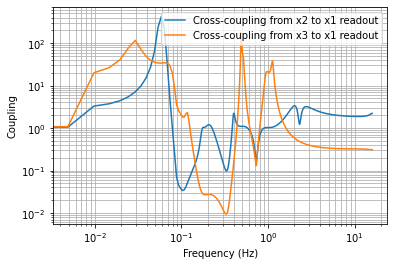

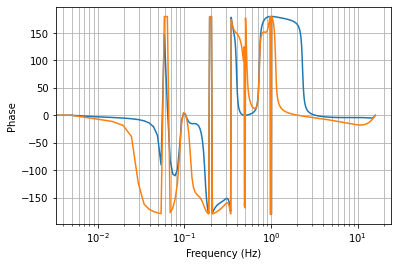

In [2]:
# Obtain the cross-couplings, or "transfer function", from x2 to x1, x3 to x1, ...
f, csd_21 = scipy.signal.csd(x2_read, x1_read, fs=fs, nperseg=int(len(t)/5))
f, csd_31 = scipy.signal.csd(x3_read, x1_read, fs=fs, nperseg=int(len(t)/5))
f, csd_12 = scipy.signal.csd(x1_read, x2_read, fs=fs, nperseg=int(len(t)/5))
f, csd_32 = scipy.signal.csd(x3_read, x2_read, fs=fs, nperseg=int(len(t)/5))
f, csd_13 = scipy.signal.csd(x1_read, x3_read, fs=fs, nperseg=int(len(t)/5))
f, csd_23 = scipy.signal.csd(x2_read, x3_read, fs=fs, nperseg=int(len(t)/5))

tf_21 = csd_21/x2_psd
tf_31 = csd_31/x3_psd
tf_12 = csd_12/x1_psd
tf_32 = csd_32/x3_psd
tf_13 = csd_13/x1_psd
tf_23 = csd_23/x2_psd

# Plotting two as an example.
plt.figure(121)
plt.loglog(f, abs(tf_21), label="Cross-coupling from x2 to x1 readout")
plt.loglog(f, abs(tf_31), label="Cross-coupling from x3 to x1 readout")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Coupling")
plt.xlabel("Frequency (Hz)")

plt.figure(122)
plt.semilogx(f, 180/np.pi*np.angle(tf_21), label="Cross-coupling from x2 to x1 readout")
plt.semilogx(f, 180/np.pi*np.angle(tf_31), label="Cross-coupling from x3 to x1 readout")
# plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Phase")
plt.xlabel("Frequency (Hz)")

Now, this cross-coupling plot is not useful at all frequencies. It's only useful where the cross-couplings are observed.
That means, for the x1 readout, we're looking at 0.1 Hz for the x2 to x1 coupling and 0.2 Hz for the x3 to x1 coupling.

In [3]:
coupling21 = tf_21[np.argmin(abs(f-0.1))]
coupling31 = tf_31[np.argmin(abs(f-0.2))]
coupling12 = tf_12[np.argmin(abs(f-0.06))]
coupling32 = tf_32[np.argmin(abs(f-0.2))]
coupling13 = tf_13[np.argmin(abs(f-0.06))]
coupling23 = tf_23[np.argmin(abs(f-0.1))]

print("Cross-couplings")
print(f"From x2 to x1 readout: mag:{abs(coupling21):.3g}, phase:{180/np.pi*np.angle(coupling21):.3g} degrees")
print(f"From x3 to x1 readout: mag:{abs(coupling31):.3g}, phase:{180/np.pi*np.angle(coupling31):.3g} degrees")
print(f"From x1 to x2 readout: mag:{abs(coupling12):.3g}, phase:{180/np.pi*np.angle(coupling12):.3g} degrees")
print(f"From x3 to x2 readout: mag:{abs(coupling32):.3g}, phase:{180/np.pi*np.angle(coupling32):.3g} degrees")
print(f"From x1 to x3 readout: mag:{abs(coupling13):.3g}, phase:{180/np.pi*np.angle(coupling13):.3g} degrees")
print(f"From x2 to x3 readout: mag:{abs(coupling23):.3g}, phase:{180/np.pi*np.angle(coupling23):.3g} degrees")

Cross-couplings
From x2 to x1 readout: mag:0.0381, phase:3.79 degrees
From x3 to x1 readout: mag:0.0273, phase:180 degrees
From x1 to x2 readout: mag:0.00233, phase:-147 degrees
From x3 to x2 readout: mag:0.0235, phase:1.38 degrees
From x1 to x3 readout: mag:0.0295, phase:-180 degrees
From x2 to x3 readout: mag:0.0175, phase:-0.923 degrees


Here, it's important to only include cross-couplings that has a phase close to 0 to 180 degrees.
If it's not 0 or 180 degrees, it's not cross-coupling resulting from sensor misalignment.
In this case, x1 to x2 coupling has a phase of -147 degrees.
From the spectrum, the x1 resonance at 0.06 Hz is not visible from the x2 readout.

In [4]:
# Construct the coupling matrix.
# Diagonals should be ones, assuming that the sensors were mostly aligned.
coupling_matrix = [
    [1, abs(coupling21), -abs(coupling31)],  # Use negative sign for phase ~180 degrees
    [0, 1, abs(coupling32)],  # Recall coupling12 is not real.
    [-abs(coupling13), abs(coupling23), 1]
]
coupling_matrix = np.array(coupling_matrix)

# Using Kontrol
sensing_matrix = kontrol.sensact.SensingMatrix(matrix=sensing_matrix)
sensing_matrix.coupling_matrix = coupling_matrix
diagonalized_matrix = sensing_matrix.diagonalize()

print(f"New sensing matrix:\n {diagonalized_matrix}")

New sensing matrix:
 [[-0.34648554 -0.30189757  0.67664218]
 [ 0.56999299 -0.58521291 -0.00830399]
 [ 0.31314695  0.33465657  0.35344143]]


Text(0.5, 0, 'Frequency (Hz)')

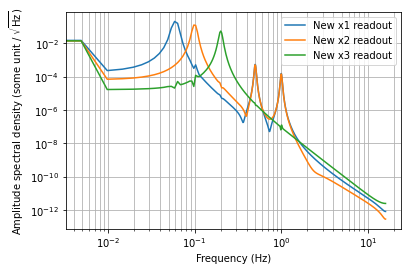

In [5]:
# Install the new matrix and obtain new readouts.
x_new = diagonalized_matrix @ y

x1_new = x_new[0, :]
x2_new = x_new[1, :]
x3_new = x_new[2, :]

f, x1_new_psd = scipy.signal.welch(x1_new, fs=fs, nperseg=int(len(t)/5))
f, x2_new_psd = scipy.signal.welch(x2_new, fs=fs, nperseg=int(len(t)/5))
f, x3_new_psd = scipy.signal.welch(x3_new, fs=fs, nperseg=int(len(t)/5))


plt.loglog(f, x1_new_psd**0.5, label="New x1 readout")
plt.loglog(f, x2_new_psd**0.5, label="New x2 readout")
plt.loglog(f, x3_new_psd**0.5, label="New x3 readout")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density (some unit / $\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
# ^As can be seen, the cross-couplings have been drastically reduced.

In [6]:
# Additional tips:
# To obtain/install the sensing matrix, use kontrol.ezca
# Commented below only works in a control workstation

# import kontrol.ezca
# ezca = kontrol.ezca.Ezca("K1:VIS-BS")
# sensing_matrix = ezca.get_matrix("IP_LVDT2EUL")  # Get matrix
# ezca.put_matrix(diagonalized_matrix, "IP_LVDT2EUL")  # Install matrix

In [7]:
# Additional tips 2:
# Sometimes there's an additional matrix after the first sensing matrix for the diaognalization purpose.
# To obtain that matrix instead, use the identity matrix when declaring the matrix option:

sensing_matrix1 = kontrol.sensact.SensingMatrix(matrix=np.eye(3), coupling_matrix=coupling_matrix)
additional_matrix = sensing_matrix1.diagonalize()
additional_matrix

SensingMatrix([[ 1.00083373e+00, -3.86143137e-02,  2.82590738e-02],
               [-6.94024575e-04,  1.00043766e+00, -2.35239074e-02],
               [ 2.95396759e-02, -1.86278778e-02,  1.00124495e+00]])

In [8]:
# The equivalent matrix is the same after the matrix multiplication.
equivalent_matrix = additional_matrix @ sensing_matrix
# ^Note that the sensor readouts passes through the sensing matrix before the additional matrix.
equivalent_matrix

SensingMatrix([[-0.34648554, -0.30189757,  0.67664218],
               [ 0.56999299, -0.58521291, -0.00830399],
               [ 0.31314695,  0.33465657,  0.35344143]])